# TORCH.AUTOGRAD를 사용한 자동미분

신경망 학습시 가장 자주 사용되는 알고리즘은 역전파(Backpropagation)임
역전파에서 매개변수(모델 가중치)는 주어진 매개변수에 대한 손실함수의 기울기에 조정됨

이를 위해 PyTorch의 torch.autograd를 이용하여 모든 그래프에 대한 변화도의 자동 계산을 지원함

In [2]:
import torch

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5,3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

## Tensor, Function과 연산 그래프(computational graph)

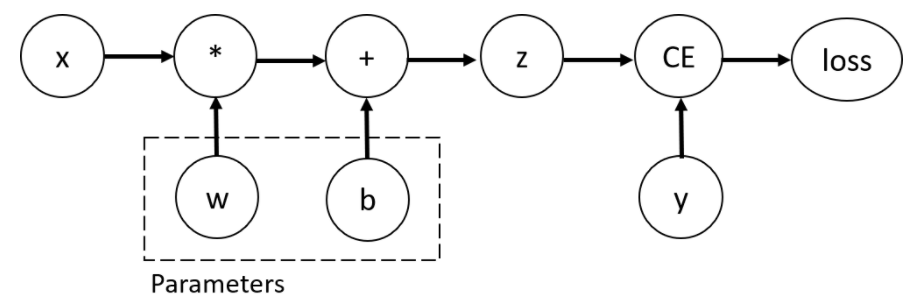

이 신경망에서 w와 b는 최적화를 해야하는 매개변수임. 따라서 해당 변수들에 대한 손실함수의 기울기 계산이 가능해야함. 이를 위해 해당 텐서에 requires_grad 속성을 설정함

** requires_grad의 값은 텐서 생성시 설정하거나, 추후 x.requires_grad_(True)메소드를 사용하여 설정가능함

In [3]:
print('Gradient function for z =', z.grad_fn)
print('Gradient function for loss =', loss.grad_fn)

Gradient function for z = <AddBackward0 object at 0x0000026E62518730>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x0000026E625187C0>


## 기울기(gradient) 계산하기 

신경망에서 매개변수의 가중치를 최적화 하기 위해선 매개변수의 손실함수에 대한 도함수를 계산해야 함
이를 위해 loss.backward()를 호출한 다음 w.grad와 b.grad에서 값을 가져옴

In [4]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1867, 0.1493, 0.1393],
        [0.1867, 0.1493, 0.1393],
        [0.1867, 0.1493, 0.1393],
        [0.1867, 0.1493, 0.1393],
        [0.1867, 0.1493, 0.1393]])
tensor([0.1867, 0.1493, 0.1393])


** 연산그래프의 리프(leaf)노드들 중 requires_graㅇ = True로 설정된 노드들의 grad 구할수 있음. 다른 노드에서의 기울기는 유효하지 않음

** 성능상의 이유로 주어지 그래프에서의 backward를 사용한 기울기 계산은 한번만 수행 가능. 여러번의 수행하기 위해선 backward 호출시 retain_graph=True로 설정해야함

## 기울기 추적 멈추기

- requires_grad=True인 모든 텐서들은 연산기록을 추적하고 기울기 계산 지원
- 모델 학습후, 입력데이터를 단순적용하는 즉, 순전파 연산만 필요한 경우 이런 추적이나 지원이 필요없음
- 연산코드를 torch.no_grad() 블록으로 둘러싸서 연산추적을 멈출수 있음

### 기울기 추적을 멈춰야 하는 이유
- 신경망의 일부 매개변수를 고정된 매개변수로 표시, 이는 사전학습된 신경망을 fine tuning 할때 일반적임
- 연산이 효율적임, 따라서 연산속도 향상

In [5]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)


True
False


#### or detach() 메소드 사용

In [6]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z.requires_grad)


True


## 연산그래프에 대한 추가 정보

개념적으로 autograd는 데이터 및 실행된 모든 연산들의 기록을 Function 객체로 구성된 '방향성 비순환 그래프(DAG)'에 저장.
이 '방향성 비순환 그래프(DAG)'의 리프노드는 입력텐서이고 뿌리는 결과 텐서임

순전파 단계에서 autograd:
- 요청된 연산 수행우 결과 텐서 계산
- DAG에 연산읜 gradient function을 유지

역전파 단계는 DAG뿌리에서 .backward()가 호출될 떄 시작, 이때 autograd는 
- 각 .grad_fn으로 부터 기울기 계산
- 각 텐서의 .grad 속성에 계산 결과를 축적
- 연쇄법칙을 사용하여 모든 리프텐서들까지 전파

## 텐서 기울기와 야코비안 곱(JAcobian Prodcut)

- 대부분의 경우, 스칼라 손실함수를 가지고 일부 매개변수롸 관련한 기울기를 계산. 
- 하지만 출력함수가 임의의 텐서인 경우 PyTorch는 야코비안 곱을 계산.


- 동일한 인자로 backward를 두차례 호출하면 기울기 값이 변경. 이는 PyTorch가 기울기를 누적 해두기 때문.
- 계산된 기울기의 값이 연산그래프의 모든 리프노드의 grad속성에 추가.
- 따라서, grad 속성을 먼저 0으로 만들어야 함. 실제 학습시 옵티마이저가 이 과정을 도움.

In [7]:
inp = torch.eye(5, requires_grad=True)
out = (inp+1).pow(2)
out.backward(torch.ones_like(inp), retain_graph=True)
print("First Call\n", inp.grad)
out.backward(torch.ones_like(inp), retain_graph=True)
print("\n Second Call\n", inp.grad)
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print("\nCall after zeroing gradients\n", inp.grad)

First Call
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])

 Second Call
 tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])

Call after zeroing gradients
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])
